#### A quick-start to calculating catchmentwide erosion rates

**This script uses the riversand v1.4** (released 2025-06-04)

Copy this jupyter notebook together with the folder `test_data` to any location on your computer.<br>
Note that a folder for output `plots` will be created in your working directory.

In [1]:
# Install the riversand package if you haven't done so, or upgrade to the latest version:
#%pip install riversand==1.4

# Workflow
The basic workflow consists of two steps: (1) Import and validate all input data; (2) calculate the catchmentwide erosion rates.

### (1) Import and validate input data:
#### Raster data
You can add three types of raster datasets (geotiffs):
- `'elevation'` is a digital elevation model in meters above sea level
- `'shielding'` is a shielding factor between 0 and 1 (e.g. topographic shielding calculated with the TopoToolbox toposhielding function)
- `'quartz'` is a binary raster with 1 indicating quartz-bearing and 0 indicating quartz-free lithologies (or decimal numbers between 0 and 1 representing the relative contribution of the lithologies to the quartz budget of the catchment)

'Nodata' values in the `shielding` and `quartz` raster datasets are interpreted as 0; pixel errors are no problem, but try to avoid nodata values in the raster datasets. 

All raster data must have the same projection and resolution. Projection must be equal area (e.g. UTM), geographic coordinate reference systems (lat/long) are not permitted. An elevation dataset is mandatory, shielding and quartz data are optional.


#### Sample data
Sample and nuclide information can be added manually or imported from a spreadsheet. The requirements are those for the online calculator (see  http://stoneage.hzdr.de/docs/documentation.html#input_format).<br>

Entries that are recognized (processed) by the calculator are `name`, `press_flag`, `thickness`, `density`, `shielding`, `erate`, `year`, `nuclide`, `mineral`, `N`, `delN` and `standardization`; any additional information is ignored. Sample location (latitude/longitude/elevation) can be specified in the spreadsheet, but nuclide production rates are computed from the elevation geotiff and the catchment outline.

A detailed description of input sample data is given at the end of this notebook.

#### Catchment shapefile
Catchments are imported from a polygon shapefile with one or several catchment outlines. The shapefile must have the same projection as the raster data. If the shapefile has more than one catchment polygon, the attribute table must include a field with unique catchment names that are used to match catchments to samples.

#### Input data validation
Use the function `.validate()` to verify projection and resolution of geospatial data and to ensure that the sample data is valid.

### (2) Calculate catchmentwide erosion rates:
There are two functions `.process_single_catchment()` and `.process_multi_catchment()` to calculate erosion rates for single-catchment and multi-catchment datasets, respectively. In addition, the function `.catchment_stats()` calculates some basic catchment statistics such as area, mean elevation, relief, etc.

# Example 1: Single catchment

In [2]:
import pandas as pd
import numpy as np

import riversand

# Create a new 'Riversand' object and specify the folder with the input data:
rv = riversand.Riversand()
rv.set_path_to_data('test_data') # subfolder in current working directory

# Add raster data:
rv.add_raster('dem_utm_35m.tif', dtype='elevation')
rv.add_raster('toposhielding_35m.tif', dtype='shielding') # optional
#rv.add_raster('quartz_35m.tif', dtype='quartz') # optional
#rv.quartz = None # remove the quartz raster

# Add sample data manually; see multi-catchment example for how to upload data from a spreadsheet
test = {'name'   : 'Ph-1',   # sample name
        'N'      : 1.2e6,    # nuclide concentration, at/g
        'delN'   : 3.6e4,    # uncertainty, at/g
        'nuclide': 'Be-10',  # nuclide 'Be-10' or 'Al-26'
        'density': 2.6,      # density, g/cm3
      }
rv.add_samples(test) # add the sample to the project

# Add catchment shapefile with a single catchment polygon:
rv.add_catchments('test_single_catchment.shp')

This cell may result in error messages, e.g. if a file does not exist or cannot be read, or warnings, e.g. if the shielding or quartz raster contains values <0 or >1.

Type `rv` to summarize the data that has been imported (type `rv.samples`, `rv.catchments`, `rv.elevation`, `rv.shielding`, `rv.quartz` to summarize the individual data sets). The function `riversand.plot_raster()` can be used to quickly display the raster data:

(Use `?riversand.plot_raster` for help.)

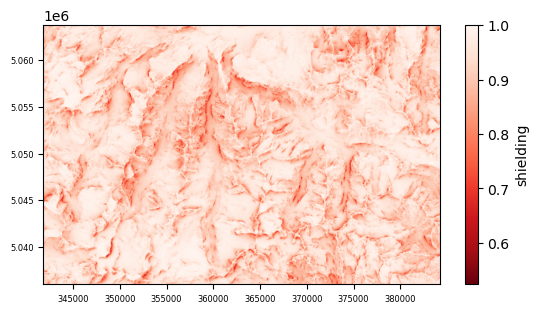

In [3]:
fig, ax = riversand.plot_raster(rv, dtype='shielding') # generate the plot
fig # display

In [4]:
rv.samples # display sample data; default values (e.g. year of sampling) have been added

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Ph-1,std,0,2.6,1.0,0,2010,Be-10,quartz,1200000.0,36000.0,07KNSTD


The function `.validate()` checks if all geospatial datasets have matching projections and resolutions. It also sets several parameters such as `.epsg`, `.crs` and `.res` that reflect the projection and resolution of the geospatial datasets.


In [5]:
# Validate the dataset:
rv.validate()


Raster data valid
Sample data valid
Catchment data valid


In [6]:
# Display summary of the data:
rv

---------------
Input data folder: 'test_data'
Output folder for plots: 'plots'

---------------
Raster data:

dtype  : elevation
fname  : test_data\dem_utm_35m.tif
src    : <closed DatasetReader name='test_data\dem_utm_35m.tif' mode='r'>
epsg   : 32632
res    : (35.0, 35.0)
values : 596 to 4022

dtype  : shielding
fname  : test_data\toposhielding_35m.tif
src    : <closed DatasetReader name='test_data\toposhielding_35m.tif' mode='r'>
epsg   : 32632
res    : (35.0, 35.0)
values : 0.5249034762382507 to 0.999800980091095

---------------
Sample data:
1 sample(s)

---------------
Catchment polygons:

fname  : test_data\test_single_catchment.shp
src    : <closed Collection 'test_data\test_single_catchment.shp:test_single_catchment', mode 'r' at 0x2bff6e062d0>
attrs  : ['name', 'id']
len    : 1
epsg   : 32632

Validated projection:
epsg   : 32632
res    : (35.0, 35.0)

### Processing
Continue only if the dataset is validated (function `.validate()`).

Use the function `.process_single_catchment()` if the shapefile contains only a single polygon; sample or catchment names are ignored.

The following parameters need to be specified:
- `bins` : bin size for elevation statistics in metres, e.g. `bins=100`
- `scaling` : scaling method as implemented in the online calculator: `'St'`, `'Lm'` or `'LSDn'`
- `shielding` : method for shielding correction:<br>
    - `'topo'` : compute from shielding raster; raises an error if no shielding raster is defined.<br>
    - `'sample'` : use value from sample dataset; raises an error if no shielding is defined for the sample.<br>
    - numeric : use a constant value between 0 and 1.

Optional parameters:
- `plot` : format for saving plots, e.g. `'jpg'`, `'png'`, `'svg'`.
- `unit` : unit of erosion rates for display; `riversand.print_units()` shows all valid options.

By default, plots are saved in a folder `'plots'` in the current working directory; use `riversand.set_folder()` and `riversand.get_folder()` to define a different output location. Existing files with identical names will be overwritten.

Although `riversand` handles all valid standardizations (see `riversand.print_standardizations()`) gracefully it is recommended to restandardize your data before calculating catchmentwide erosion rates to avoid confusion. Note that the function `.process_single_catchment()` restandardizes sample data (and `rv.samples` is updated accordingly).

In [7]:
# Process a single catchment:
riversand.set_folder('example1')
results1 = rv.process_single_catchment(bins=100, # bin size in meters
                                       scaling='LSDn', # 'St', 'Lm', 'LSDn'
                                       shielding='topo', # 'topo', 'sample' or numeric
                                       plot='png', # e.g. 'jpg' or 'png'
                                       unit='mm/kyr') # units for plotting

Processing single catchment
Bin size : 100 m
Scaling method : LSDn
Topographic shielding from topo data
Saving plots as .png in 'example1'

Processing finished.


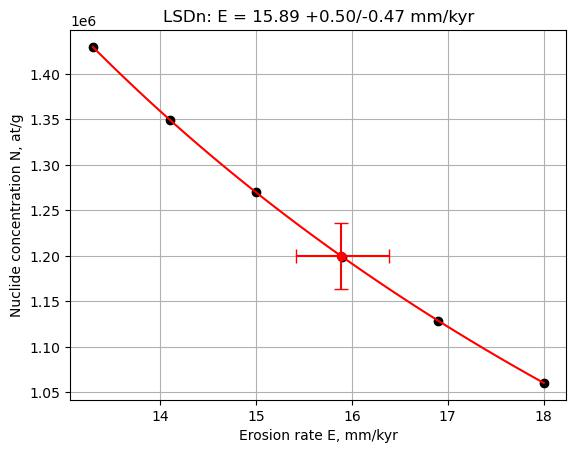

If the parameter `plot` is set a figure is saved as `0_Ph-1_LSDn.jpg` in the folder specified by `riversand.set_folder()` (default: `'plots'`):
- The black points are six initial erosion rates $E$ sent to the online calculator and the nuclide concentrations $N(E)$ predicted by the online calculator.
- The red curve is a polynomial fit $N(E)$.
- The red point and vertical error bar are the input nuclide concentration and uncertainty of the sample $N\pm delN$.
- The horizontal error bar is the uncertainty on the erosion rate resulting from the analytical uncertainty $delN$; it depends on the shape of the function $N(E)$ and is therefore asymmetric although difference between $+delN$ and $-delN$ is generally not significant.

Note that the units for this plot are defined by the parameter `unit`.

**Results table**:
- `E`, `delE-`, `delE+`: erosion rate and uncertainty in cm/yr
- `NRMSE`: normalised root mean squared error
- `Tavg`: averaging time scale in yr

Use `.to_excel()` to save the results to Excel or OpenOffice or `.to_csv()` for comma-separated values. This may require additional packages such as `openpyxl` or `odfpy`.

In [8]:
results1 # display results (cm/yr)

,name,scaling,nuclide,E,delE-,delE+,NRMSE,Tavg,error
0,Ph-1,LSDn,Be-10 quartz,0.001589,0.000047,0.00005,0.000113,38738,


In [9]:
results1.to_excel('Example1_LSDn.xlsx') # save data to spreadsheet

Calculate some **catchment statistics** for this catchment. Note that in this example the catchment name has not been specified (see below).

In [10]:
stats1 = rv.catchment_stats()
stats1 # display catchment statistics

Processing  finished.


,name,centr_lat,centr_long,mean_elev,stdev_elev,median_elev,relief,area,mean_sf,error
0,,45.59974,7.34807,2453.7,561.7,2532.0,3382.0,257.6,0.92309,


# Example 2: Same catchment, different settings
Repeat the analysis with a **correction for quartz-free lithologies** and with a **constant shielding factor** of 0.95.

In [11]:
# Add a quartz raster dataset:
rv.add_raster('quartz_35m.tif', dtype='quartz')
rv.validate()


Raster data valid
Sample data valid
Catchment data valid


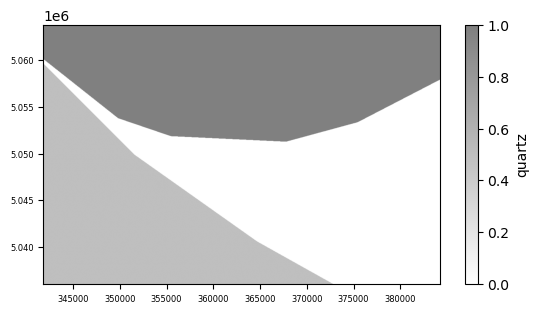

In [12]:
# Show the quartz distribution in the area:
fig, ax = riversand.plot_raster(rv, dtype='quartz')
fig

In [13]:
# Process with a constant shielding factor 'shielding=0.95':
riversand.set_folder('example2')
results2 = rv.process_single_catchment(bins=100, # bin size in meters
                                       scaling='LSDn', # 'St', 'Lm' or 'LSDn'
                                       shielding=0.95, # 'topo', 'sample' or numeric
                                       plot='png', # e.g. 'jpg' or 'png'
                                       unit='mm/kyr') # units for plotting
results2 # display results (cm/yr)

Processing single catchment
Bin size : 100 m
Scaling method : LSDn
Topographic shielding : 0.95
Correcting for quartz-free lithologies
Saving plots as .png in 'example2'

Processing finished.


,name,scaling,nuclide,E,delE-,delE+,NRMSE,Tavg,error
0,Ph-1,LSDn,Be-10 quartz,0.001349,0.00004,0.000042,0.000073,45610,


In [14]:
results2.to_excel('Example2_LSDn.xlsx') # save data to spreadsheet


# Example 3: Multi-catchment dataset
To process a shapefile with more than one catchment polygon, import sample data from a spreasdsheet. The spreadsheet must have a column `name` with sample names that are used to match samples to catchment polygons. **The shapefile must have an attribute field with the sample names.** Use the function `.set_cid()` to specify, which attribute field of the shapefile to use.

In [15]:
# Create a new Riversand object:
rv = riversand.Riversand()
rv.set_path_to_data('test_data')

# Add raster data:\n",
rv.add_raster('dem_utm_35m.tif', dtype='elevation')
rv.add_raster('toposhielding_35m.tif', dtype='shielding') # optional
rv.add_raster('quartz_35m.tif', dtype='quartz') # optional

# Add sample data from a spreadsheet:
rv.add_samples('test_samples.ods') # .xlsx, .ods, .csv

# Add catchment shapefile with one or several catchment polygons:
rv.add_catchments('test_multi_catchment.shp')
# Set the catchment identifier:
rv.set_cid('name') # mandatory for shapefiles with more than one catchment

rv.validate()

Using default values for missing columns:
   press_flag, thickness, erate, year, mineral, standardization

Raster data valid
Sample data valid
Catchment data valid

Valid catchments / samples:
   Found 5 match(es)


For a multi-catchment dataset the function `.validate()` displays how many catchments with matching sample data have been found. The valid catchment names are stored in `.valid_catchments` (see also `.get_valid_catchments()`).

If the result is not what you expect the following functions / variables help trouble-shooting:

```python
rv.catchments.get_names()  # list all catchment names; note that non-unique names are invalid
rv.samples  # display all samples
rv.samples.name  # display all sample names
rv.catchments.cid  # show the attribute field used for catchment names
rv.catchments.attrs  # list all available attribute fields
```

In [16]:
rv.valid_catchments # list names of valid catchments

['DB02', 'DB03', 'DB05', 'DB12', 'DB17']

### Multi-catchment processing
The function `.process_multi_catchment()` is equivalent to the single-catchment processing but iterates over all samples and computes erosion rates for matching catchment-sample pairs. The function restandardizes sample data, and `rv.samples` is updated accordingly.

In [17]:
# Process a multi-catchment dataset:
riversand.set_folder('example3')
results = rv.process_multi_catchment(bins=100, # bin size in meters
                                     scaling='LSDn', # 'St', 'Lm' or 'LSDn'
                                     shielding='topo', # 'topo', 'sample' or numeric
                                     plot='png', # 'jpg' or 'png'
                                     unit='mm/kyr') # units for plotting

Processing multi-catchment dataset
Bin size : 100 m
Scaling method : LSDn
Topographic shielding from topo data
Correcting for quartz-free lithologies
Saving plots as .png in 'example3'


 0 DB01 : no catchment polygon
 1 DB02 : catchment out of bounds
 2 DB03 : 719.1+/-46.2 mm/kyr
 3 DB04 : no catchment polygon
 4 DB05 : 764.1+/-40.0 mm/kyr
 5 DB06 : no catchment polygon
 6 DB07 : no catchment polygon
 7 DB08 : no catchment polygon
 8 DB12 : catchment out of bounds
 9 DB17 : 643.4+/-33.0 mm/kyr

Processing finished.


**In this example** several samples in the spreadsheet do not have a corresponding catchment polygon in the shapefile; one sample (DB02) has a catchment polygon which is partly outside of the area covered by the input raster datasets:

In [18]:
results

,name,scaling,nuclide,E,delE-,delE+,NRMSE,Tavg,error
0,DB01,LSDn,Be-10 quartz,NaN,NaN,NaN,NaN,NaN,no catchment polygon
1,DB02,LSDn,Be-10 quartz,NaN,NaN,NaN,NaN,NaN,catchment out of bounds
2,DB03,LSDn,Be-10 quartz,0.071909,0.004078,0.004616,0.00026,824,
3,DB04,LSDn,Be-10 quartz,NaN,NaN,NaN,NaN,NaN,no catchment polygon
4,DB05,LSDn,Be-10 quartz,0.076406,0.003623,0.003999,0.000339,775,
5,DB06,LSDn,Be-10 quartz,NaN,NaN,NaN,NaN,NaN,no catchment polygon
6,DB07,LSDn,Be-10 quartz,NaN,NaN,NaN,NaN,NaN,no catchment polygon
7,DB08,LSDn,Be-10 quartz,NaN,NaN,NaN,NaN,NaN,no catchment polygon
8,DB12,LSDn,Be-10 quartz,NaN,NaN,NaN,NaN,NaN,catchment out of bounds
9,DB17,LSDn,Be-10 quartz,0.064342,0.003,0.003298,0.000186,921,


**Results table**:

- `E`, `delE+` and `delE-` are the catchmentwide erosion rate and (asymmetric) uncertainty in cm/yr.
- `NRMSE` is the normalized root mean squared error; a warning is issued for samples with NRMSE>1e-3 indicating a poor fit of the polynomial function.
- `Tavg` is the averaging time scale in yr.
- `error` indicates errors or warnings that may have occurred during the calculation.

The table has the same ordering of the samples as the input table `rv.samples` for easy merging of the spreadsheets.

Drop empty rows with `results = results.dropna()` if desired.

Catchment statistics (function `.catchment_stats()`) are calculated for all catchments regardless of duplicate catchment names or missing sample data, but if the shapefile has more than one catchment polygon the catchment identifier (`cid`) must be set.

In [19]:
results.to_excel('Example3_LSDn.xlsx') # save data to spreadsheet

In [20]:
# same table without the empty rows:
results.dropna()

,name,scaling,nuclide,E,delE-,delE+,NRMSE,Tavg,error
2,DB03,LSDn,Be-10 quartz,0.071909,0.004078,0.004616,0.00026,824,
4,DB05,LSDn,Be-10 quartz,0.076406,0.003623,0.003999,0.000339,775,
9,DB17,LSDn,Be-10 quartz,0.064342,0.003,0.003298,0.000186,921,


In [21]:
stats3 = rv.catchment_stats()
stats3 = stats3.dropna() # remove empty rows
stats3 # display catchment statistics

Processing DB03, DB04, DB02, DB05, DB19, DB17, DB12, DB04 finished.


,name,centr_lat,centr_long,mean_elev,stdev_elev,median_elev,relief,area,mean_sf,error
1,DB03,45.55922,7.20885,2509.0,560.6,2612.0,3307.0,147.7,0.92084,
2,DB04,45.5647,7.16756,2447.2,571.3,2550.0,3357.0,280.7,0.91892,
3,DB04,45.5647,7.16756,2447.2,571.3,2550.0,3357.0,280.7,0.91892,
4,DB05,45.59974,7.34807,2453.7,561.7,2532.0,3382.0,257.6,0.92309,
6,DB17,45.60825,7.05543,2426.5,519.8,2495.0,2985.0,158.3,0.93202,


# Sample data
(see also http://stoneage.hzdr.de/docs/documentation.html#input_format)

Columns that are recognized (processed) by the calculator are `name`, `press_flag`, `thickness`, `density`, `shielding`, `erate`, `year`, `nuclide`, `mineral`, `N`, `delN` and `standardization`. Additional columns are ignored.

Mandatory columns are:
- `name` : Sample name consisting of letters, numbers and hyphens; avoid names that may be misinterpreted as numbers: use 'A2' instead of '2'.
- `N` and `delN` : Nuclide concentration and uncertainty in atoms/grams quartz.

Optional columns are:
- `press_flag` : Atmospheric pressure model, 'std' or 'ant'; the default is 'std'.
- `density` : Subtrate density in g/cm$^3$; the default is 2.65 g/cm$^3$.
- `year` : Year of sampling; the default is 2010.
- `nuclide` : 'Be-10' or 'Al-26'; the default is 'Be-10'.
- `shielding` : A catchmentwide shielding factor; these values are ignored if shielding is calculated from a raster dataset, the default is 1.
- `standardization` : see http://stoneage.hzdr.de/docs/documentation.html#standardization; requires a column `nuclide`.

**Default values** (see `riversand.print_defaults()`) are used if a column is missing. Columns `thickness`, `erate` and `mineral` (only valid value: 'quartz') are irrelevant for the calculation of catchmentwide erosion rates, but if they are present they must contain valid values.


The calculator assumes default **standardizations** of '07KNSTD' for Be-10 and 'KNSTD' for Al-26 data. If the samples have been measured against other standards re-standardize the data before importing into `riversand`. 
Alternatively, use the function `.restandardize()` to re-standardize the data after importing. The correction factors used for re-standardization can be displayed with `riversand.print_standardizations()`.<br>
(see http://hess.ess.washington.edu/math/docs/al_be_v22/AlBe_standardization_table.pdf)

The **sample name** `name` is used to match samples to catchment polygons. If several samples were measured from the same location, or if both Al-26 and Be-10 were measured, the data must be in separate rows with the same sample name (additional information may be stored in a custom separate colum).


In [22]:
# Demo of restandardization:

rv = riversand.Riversand()
rv.set_path_to_data('test_data')

# Add sample data from a spreadsheet:
# Note invalid standardization and missing nuclide concentration for two samples (lines 3 and 4; line counting starts with 0!!) 
rv.add_samples('test_samples_standard.ods')
rv.samples

Using default values for missing columns:
   press_flag, thickness, erate, year, mineral
Error adding sample data from file:
   Invalid / missing data in line(s): 3, 4


,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization,lat,long,elev
0,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.0,700.0,07KNSTD,45.8040,6.9653,1230
1,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,14267.0,774.0,KNSTD,45.8040,6.9653,1230
2,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,14924.0,810.0,LLNL3000,45.8040,6.9653,1230
3,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.0,700.0,xyz,45.8040,6.9653,1230
4,DB07,std,0,2.7,0.95,0,2010,Al-26,quartz,NaN,NaN,KNSTD,45.5962,7.7956,325
5,DB07,std,0,2.7,0.95,0,2010,Al-26,quartz,22039.0,2547.0,ASTER,45.5962,7.7956,325


In [23]:
rv.restandardize()
rv.samples

Nuclide data converted to default standardizations Be-10: 07KNSTD; Al-26: KNSTD.


,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization,lat,long,elev
0,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.0000,700.0000,07KNSTD,45.8040,6.9653,1230
1,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.2214,699.8508,07KNSTD,45.8040,6.9653,1230
2,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.3056,700.1640,07KNSTD,45.8040,6.9653,1230
3,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,NaN,NaN,,45.8040,6.9653,1230
4,DB07,std,0,2.7,0.95,0,2010,Al-26,quartz,NaN,NaN,,45.5962,7.7956,325
5,DB07,std,0,2.7,0.95,0,2010,Al-26,quartz,22501.8190,2600.4870,KNSTD,45.5962,7.7956,325


In [24]:
# To use this table to calculate catchmentwide erosion rates, drop the lines with missing / invalid data
# or fix the problems in the spreadsheet and import again
rv.samples = rv.samples.dropna()
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization,lat,long,elev
0,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.0000,700.0000,07KNSTD,45.8040,6.9653,1230
1,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.2214,699.8508,07KNSTD,45.8040,6.9653,1230
2,DB01,std,0,2.7,0.92,0,2010,Be-10,quartz,12900.3056,700.1640,07KNSTD,45.8040,6.9653,1230
5,DB07,std,0,2.7,0.95,0,2010,Al-26,quartz,22501.8190,2600.4870,KNSTD,45.5962,7.7956,325


## Version of the online calculator

In [25]:
# Get the version of the **online calculator** used for the calculation:
riversand.get_version()

{'wrapper': '3.0',
 'validate': 'validate_v3_input.m - 3.0',
 'erates': '3.0',
 'muons': '3.2',
 'consts': '2024-06-10'}

In [26]:
# Get the version of your **riversand** installation (use %pip install riversand==1.3.9 to update to version 1.3.9)
riversand.__version__

'1.3.9'

# NEW since version 1.3.1: Reprojection of raster datasets

The file `toposhielding_noproj.tif` generated with Matlab TopoToolbox from the DEM `dem_utm_35m.tif` lacks a coordinate reference system (although its geotransform is stored in the accompanying file `.tfw`). Adding the raster in ArcGIS or QGIS results in a warning "Layer has no coordinate reference system set!" or similar. Adding the file in `riversand` also gives a warning, and `.validate()` will fail.

Similarly, the projection and resolution of the file `quartz_utm31N.tif` are different from the DEM and cause trouble.

The new function `.reproject()` reprojects elevation, shielding and quartz rasters to match the projection and resolution of the DEM. Data are stored in a folder `rv_reprojected` in the current working directory. The reprojected tiffs have target aligned pixels and the resolution is rounded to the nearest integer.

In [27]:
rv = riversand.Riversand()
rv.set_path_to_data('test_data') # subfolder in current working directory

# Add raster data:
rv.add_raster('dem_utm_35m.tif', dtype='elevation')

# Projection is missing (epsg:None):
rv.add_raster('toposhielding_noproj.tif', dtype='shielding')
rv.shielding

dtype  : shielding
fname  : test_data\toposhielding_noproj.tif
src    : <closed DatasetReader name='test_data\toposhielding_noproj.tif' mode='r'>
epsg   : None
res    : (35.0, 35.0)
values : 0.5176194906234741 to 0.9998186826705933

In [28]:
# Projection and resolution are different from DEM (epsg:32631 vs epsg:32632):
rv.add_raster('quartz_utm31N.tif', dtype='quartz') # optional
rv.quartz

dtype  : quartz
fname  : test_data\quartz_utm31N.tif
src    : <closed DatasetReader name='test_data\quartz_utm31N.tif' mode='r'>
epsg   : 32631
res    : (35.039110559495676, 35.039110544216854)
values : 0.0 to 1.0

In [29]:
# Validation fails
rv.validate()


Conflicting projections in raster data
No sample data defined
No catchment data defined


In [30]:
# Explore the projection and resolution with rv.elevation.crs, rv.elevation.res, etc.
#rv.elevation.crs

In [31]:
# Reproject all rasters:
rv.reproject()

Writing new file 'rv_elevation.tif'
No crs defined for 'shielding', assuming same as 'elevation'
Writing new file 'rv_shielding.tif'
Writing new file 'rv_quartz.tif'


In [32]:
# Raster data can be validated:
rv.validate()


Raster data valid
No sample data defined
No catchment data defined


# NEW since version 1.2.3: Point-based ages and erosion rates

The `riversand` package can also be used to calculate point-based erosion rates or exposure ages: Instead of copying sample information into the online calulator and having the results displayed in a browser window you can read the data from an excel spreadsheet or csv-file and retrieve the results from the server as a data table that you can save to a file or manipulate with python (e.g. if you write your own plotting functions).

```python
# Read data from a file (using pandas DataFrame):
import pandas as pd
raw_data = pd.read_excel('./folder/file.xlsx')

# Validate the data and recast for exchange with the online calculator.
# This function prints messages if the input data is ambiguous or incomplete and
# returns an empty DataFrame if the problems cannot be resolved (e.g. by filling in default values).
df = riversand.import_data(raw_data)
# The data can be restandardized (optional): 
riversand.restandardize(df)

# Convert the data table to a string (which can be copied into the online calculator if desired):
textblock = riversand.get_textblock(df)

# Calculate exposure ages or erosion rate
ages, diagnostics, version = riversand.get_ages_from_server(textblock) # in yr
erates, diagnostics, version = riversand.get_erates_from_server(textblock) # in g/cm2/yr


# Or short:
import pandas as pd
raw_data = pd.read_excel('./folder/file.xlsx')
df = riversand.import_data(raw_data)
ages, diagnostics, version = riversand.get_ages_from_server(df) # ages in yr
erates, diagnostics, version = riversand.get_erates_from_server(df) # erosion rates in g/cm2/yr
```

The requirements for the input spreadsheet are described in the docstring of `riversand.import_data()`:
- Column names are mostly case-insensitive; some aliases are accepted, e.g. latitude can be specified as `lat` or `latitude`.
- Nuclide information can be specified in two ways:<br>
Either in five columns `N`, `delN`, `nuclide`, `mineral`, `standardization`;<br>
or in columns `Be`, `Be_uncert`, `Be_std` and/or `Al`, `Al_uncert`, `Al_std`.<br>
- Default values are inserted for missing columns (see `riversand.print_defaults()`.


In [33]:
import pandas as pd
raw_data = pd.read_excel('./test_data/test_point_ages1.ods') # nuclide data as N, delN, nuclide
raw_data

,Name,Latitude,Longitude,Elevation,thickness,density,shielding,erate,nuclide,N,delN,standardization
0,DB01,45.8040,6.9653,1230,2,2.7,0.92,0.0001,Be-10,18900.0,700.0,07KNSTD
1,DB01,45.8040,6.9653,1230,2,2.7,0.92,0.0001,Al-26,113400.0,4200.0,ASTER
2,DB04,45.7003,7.2019,664,2,2.7,0.94,0.0001,Al-26,22000.0,1100.0,ASTER
3,DB08,45.6118,7.7310,373,2,2.7,0.96,0.0001,Be-10,NaN,NaN,NaN
4,DB12,45.7183,7.2651,594,2,2.7,0.95,0.0001,Be-10,20000.0,800.0,07KNSTD


In [34]:
df = riversand.import_data(raw_data)
df

No column 'press_flag', assuming default value 'std'.
No column 'year', assuming default value 2010.
No nuclide data for samples: DB08.


,name,lat,long,elevation,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,DB01,45.8040,6.9653,1230,std,2,2.7,0.92,0.0001,2010,Be-10,quartz,18900.0,700.0,07KNSTD
1,DB01,45.8040,6.9653,1230,std,2,2.7,0.92,0.0001,2010,Al-26,quartz,113400.0,4200.0,ASTER
2,DB04,45.7003,7.2019,664,std,2,2.7,0.94,0.0001,2010,Al-26,quartz,22000.0,1100.0,ASTER
3,DB12,45.7183,7.2651,594,std,2,2.7,0.95,0.0001,2010,Be-10,quartz,20000.0,800.0,07KNSTD


In [35]:
#riversand.restandardize(df) # optional

In [36]:
textblock = riversand.get_textblock(df)
textblock

'DB01 4.580e+01 6.965e+00 1.2300e+03 std 2.0 2.7 9.200e-01 1.000e-04 2010; DB04 4.570e+01 7.202e+00 6.6400e+02 std 2.0 2.7 9.400e-01 1.000e-04 2010; DB12 4.572e+01 7.265e+00 5.9400e+02 std 2.0 2.7 9.500e-01 1.000e-04 2010; DB01 Be-10 quartz 18900.0 700.0 07KNSTD; DB01 Al-26 quartz 113400.0 4200.0 ASTER; DB04 Al-26 quartz 22000.0 1100.0 ASTER; DB12 Be-10 quartz 20000.0 800.0 07KNSTD;'

In [37]:
# Calculate exposure ages or erosion rate
ages, diagnostics, version = riversand.get_ages_from_server(textblock) # in yr
#erates, diagnostics, version = riversand.get_erates_from_server(textblock) # in g/cm2/yr
ages

,name,nuclide,St_age,St_interr,St_exterr,Lm_age,Lm_interr,Lm_exterr,LSDn_age,LSDn_interr,LSDn_exterr
0,DB01,Be-10,1819,68,159,1771,66,148,1754,65,122
1,DB01,Al-26,1590,59,176,1541,57,156,1519,56,143
2,DB04,Al-26,478,24,55,453,23,48,451,23,45
3,DB12,Be-10,3143,126,279,3045,122,260,3127,126,224


In [38]:
raw_data = pd.read_excel('./test_data/test_point_ages2.ods') # nuclide data as Al, Be
raw_data

,Name,Latitude,Longitude,Elevation,thickness,density,shielding,erate,Al,Al_uncert,Al_std,Be,Be_uncert
0,DB01,45.8040,6.9653,1230,2,2.7,0.92,0.0001,113400.0,4200.0,ASTER,18900.0,700.0
1,DB04,45.7003,7.2019,664,2,2.7,0.94,0.0001,22000.0,1100.0,ASTER,NaN,NaN
2,DB08,45.6118,7.7310,373,2,2.7,0.96,0.0001,NaN,NaN,NaN,NaN,NaN
3,DB12,45.7183,7.2651,594,2,2.7,0.95,0.0001,NaN,NaN,NaN,20000.0,800.0


In [39]:
# Calculate exposure ages or erosion rate
ages, diagnostics, version = riversand.get_ages_from_server(raw_data) # in yr
#erates, diagnostics, version = riversand.get_erates_from_server(textblock) # in g/cm2/yr
ages

No column 'press_flag', assuming default value 'std'.
No column 'year', assuming default value 2010.
No column 'Be_standardization', assuming default values (Be-10: 07KNSTD).
No nuclide data for samples: DB08.


,name,nuclide,St_age,St_interr,St_exterr,Lm_age,Lm_interr,Lm_exterr,LSDn_age,LSDn_interr,LSDn_exterr
0,DB01,Be-10,1819,68,159,1771,66,148,1754,65,122
1,DB01,Al-26,1590,59,176,1541,57,156,1519,56,143
2,DB04,Al-26,478,24,55,453,23,48,451,23,45
3,DB12,Be-10,3143,126,279,3045,122,260,3127,126,224


In [40]:
print(diagnostics) # returned from server, e.g. saturation of samples

No diagnostics


In [41]:
version # returned from server

{'wrapper': '3.0.2',
 'validate': 'validate_v3_input.m - 3.0',
 'get_age': '3.0.2',
 'muons': '1A, alpha = 1',
 'consts': '2024-06-10'}